<a class="anchor" id="0.0"></a>

#  IMPORT LIBARAIES

In [159]:
import time 
import numpy as np 
import pandas as pd
import matplotlib 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9,6)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split


<a class="anchor" id="1.0"></a>

#  LOAD DATA

<a class="anchor" id="1.1"></a>

###  Load banglore home prices dataset

In [87]:
df = pd.read_csv('Bengaluru_House_Data.csv',encoding='unicode_escape')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,$39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,$120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,$62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,$95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,$51.00


In [88]:
df.shape

(13320, 9)

In [89]:
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [90]:
df.columns.dtype

dtype('O')

In [91]:
df.area_type.unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [92]:
df.groupby('area_type').area_type.agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [93]:
df.area_type.value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

<a class="anchor" id="1.2"></a>

###  Drop unnecessary features

In [94]:
# Drop features that are not required to build our model
df2 = df.drop(['availability', 'society', 'balcony', 'area_type'], axis=1)
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,$39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,$120.00
2,Uttarahalli,3 BHK,1440,2.0,$62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,$95.00
4,Kothanur,2 BHK,1200,2.0,$51.00


<a class="anchor" id="2.0"></a>

#  DATA CLEANING

<a class="anchor" id="2.1"></a>

##  Handle null values

In [95]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

Null is a small number so we can simply drop this records

In [96]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [97]:
df3.shape

(13246, 5)

<a class="anchor" id="2.2"></a>

## Add new feature (Bedrooms Hall Kitchen)

In [98]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [99]:
# Add new feature(integer) for bhk (Bedrooms Hall Kitchen)
df3['bedroom'] = df3['size'].apply(lambda s: int(s.split(' ')[0]))

In [100]:
df3.bedroom.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

<a class="anchor" id="2.3"></a>

## Fix total_sqft feature

In [101]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [102]:
def check_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [103]:
df3[~df3.total_sqft.apply(check_float)]['total_sqft'].sample(10)

6592       697Sq. Meter
11490       2580 - 2591
7412        1450 - 1950
4884         888 - 1290
9147        1079 - 1183
2716        1300 - 1405
1187         850 - 1093
410      34.46Sq. Meter
13265       1133 - 1384
8023        4900 - 4940
Name: total_sqft, dtype: object

> Taking the avarage of the range in the total_sqft column

> There are other cases such as 34.46Sq. Meter , 2940Sq. Yards, and 1574Sq. Yards. I am going to just drop them as they are small number of records.

In [104]:
# This function return the avarage of the range numbers 
# or return None in the case of ( 34.46Sq. Meter , 2940Sq. Yards, and 1574Sq.)

def fix_total_sqft(x):
    
    range_ = x.split('-')
    
    if len(range_) == 2:
        return (float(range_[0]) + float(range_[0]) )/2
    else:
        try:
            return float(x)
        except:
            return None

In [105]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(fix_total_sqft)

In [106]:
df4.isna().sum()

location       0
size           0
total_sqft    46
bath           0
price          0
bedroom        0
dtype: int64

> 46 null due to the vales like this ( 34.46Sq. Meter , 2940Sq. Yards, and 1574Sq.)

In [107]:
df4.dropna(inplace = True);

In [108]:
df4.isna().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
bedroom       0
dtype: int64

<a class="anchor" id="2.4"></a>

## Add new feature called price per square feet

In [109]:
df5 = df4.copy()
#df5.info()
df5['price'].replace(r'\.(?=\d*\.)', '', regex=True, inplace=True)
df5['price'].replace(r'[^0-9.]', '', regex=True, inplace=True)
df5['price'].replace(r'\.(?=\d*\.)', '', regex=True, inplace=True)
df5['price'].replace(r'\.{2,}', '.', regex=True, inplace=True)
df5[["price"]] = df5[["price"]].apply(pd.to_numeric)


df5['price_per_sqft'] = df5.price * 100000 / df5.total_sqft

In [110]:
df5.price_per_sqft.describe()

count    1.320000e+04
mean     9.227791e+03
std      1.478797e+05
min      2.678298e+02
25%      4.271723e+03
50%      5.446151e+03
75%      7.325783e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

<a class="anchor" id="2.5"></a>

## Dimensionality reduction

In [111]:
len(df5['location'].unique())

1298

> We need to apply dimensionality reduction technique here to reduce number of locations

<a class="anchor" id="2.5.1"></a>

### Decrease (location) feature dimension
Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. 
Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [112]:
df5.location = df5.location.apply(lambda x: x.strip())
locs = df5.location.value_counts(ascending=False)
locs

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

In [113]:
len(locs[locs > 10])

240

In [114]:
loc_list = locs[locs.values <= 10]

In [115]:
df5['location'] = df5['location'].apply(lambda l: 'other' if  l in loc_list else l)

In [116]:
len(df5.location.unique())

241

<a class="anchor" id="2.6"></a>

## Outlier removal

<a class="anchor" id="2.6.1"></a>

### Outlier removal from (price_per_sqft) feature according to business logic
Normally square ft per bedroom is 300.If you have for example 400 sqft apartment with 2 bedroom than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft


In [117]:
len(df5[ (df5.total_sqft/df5.bedroom) <300])

746

In [118]:
df6 = df5[~ ( (df5.total_sqft/df5.bedroom) < 300) ]
df6.shape

(12454, 7)

<a class="anchor" id="2.6.2"></a>

### Outlier removal from (price_per_sqft) feature according to std and mean


In [119]:
df6.price_per_sqft.describe()

count    1.245400e+04
mean     7.693873e+03
std      1.054852e+05
min      2.678298e+02
25%      4.214345e+03
50%      5.299842e+03
75%      6.923077e+03
max      9.716157e+06
Name: price_per_sqft, dtype: float64

> Here we find that min price per sqft is 267.829813 whereas max is 176470.588235, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [120]:
def remove_outliers_std(df, by='location',factor = 1):
    df_new = pd.DataFrame()
    for key, subdf in df.groupby(by):
        mean = subdf.price_per_sqft.mean()
        std = subdf.price_per_sqft.std()
        
        out1 = (subdf.price_per_sqft>(mean-factor * std))
        out2 = (subdf.price_per_sqft<=(mean+factor * std))
        
        reduced_df = subdf[out1 & out2]
        
        df_new = pd.concat([df_new,reduced_df],ignore_index=True)
    return df_new

In [121]:
df7 = remove_outliers_std(df6)
df7.shape

(10545, 7)

<a class="anchor" id="2.6.4"></a>

### Outlier removal from (bath) feature according to business logic
remove qny records NOT subject to this equation:
$$ \text{max number of bathrooms} =< \text{number of bedrooms} + 2$$

In [122]:
df7.bath.describe()

count    10545.000000
mean         2.501944
std          1.016098
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: bath, dtype: float64

In [123]:
print(df7.shape)
df7[df7.bath > (df7.bedroom + 1)]

(10545, 7)


,location,size,total_sqft,bath,price,bedroom,price_per_sqft
36,2nd Stage Nagarbhavi,6 Bedroom,3000.00,8.0,451.0,6,15033.333333
37,2nd Stage Nagarbhavi,6 Bedroom,2400.00,8.0,450.0,6,18750.000000
544,Arekere,4 BHK,2710.00,6.0,142.0,4,5239.852399
594,BTM 2nd Stage,3 Bedroom,1260.00,5.0,185.0,3,14682.539683
827,Bannerghatta,4 BHK,3012.00,6.0,250.0,4,8300.132802
...,...,...,...,...,...,...,...
10447,other,4 BHK,4750.00,6.0,948.0,4,19957.894737
10449,other,3 BHK,2777.29,5.0,649.0,3,23368.103439
10499,other,5 BHK,5665.84,7.0,988.0,5,17437.837990
10502,other,4 BHK,6652.00,6.0,660.0,4,9921.828022


> There are 81 records has bathrooms > bedrooms + 1 ==> remove them

In [124]:
df8 = df7[df7.bath <= (df7.bedroom + 1)]

In [125]:
df8[df7.bath > (df7.bedroom + 1)]
print(df8.shape)

(10436, 7)


<a class="anchor" id="2.6.3"></a>

### Outlier removal from (bedroom) feature according to business logic


In [126]:
df8.location.unique()[:10]

array(['1st Block Jayanagar', '1st Phase JP Nagar',
       '2nd Phase Judicial Layout', '2nd Stage Nagarbhavi',
       '5th Block Hbr Layout', '5th Phase JP Nagar', '6th Phase JP Nagar',
       '7th Phase JP Nagar', '8th Phase JP Nagar', '9th Phase JP Nagar'],
      dtype=object)

In [127]:
def scatter_plot(df,loc,size = (9,6)):

    matplotlib.rcParams['figure.figsize'] = size

    bedroom2 = df[ (df.location==loc) & (df.bedroom == 2) ]
    bedroom3 = df[ (df.location==loc) & (df.bedroom == 3) ]
    bedroom4 = df[ (df.location==loc) & (df.bedroom == 4) ]
    
    fig, ax = plt.subplots()

    plt.scatter(bedroom2.total_sqft, bedroom2.price, color = '#10C595',label = '2 bedrooms',marker='*',s=100)
    plt.scatter(bedroom3.total_sqft, bedroom3.price, color = '#8844E7',label = '3 bedrooms',marker='+',s=100)
    plt.scatter(bedroom4.total_sqft, bedroom4.price, color = '#E71515',label = '4 bedrooms',marker='.',s=100)
    

    xticks = ax.get_xticks()
    mean2=[bedroom2['price'].mean()]*len(xticks)
    mean3=[bedroom3['price'].mean()]*len(xticks)
    mean4=[bedroom4['price'].mean()]*len(xticks)
    
    plt.plot(xticks,mean2,'--', label='Mean of 2 bedrooms',color = '#10C595')
    plt.plot(xticks,mean3,'--', label='Mean of 3 bedrooms',color = '#8844E7')
    plt.plot(xticks,mean4,'--', label='Mean of 4 bedrooms',color = '#E71515')

    plt.xlabel("Total Square Feet Area",fontsize= 14)
    plt.ylabel("Price",fontsize= 14)
    plt.title(loc, fontsize = 18)
    plt.legend()

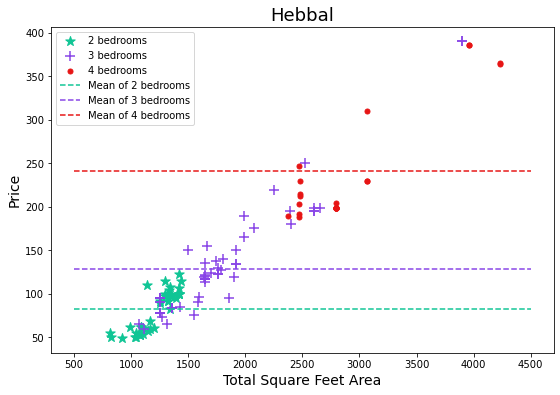

In [128]:
scatter_plot(df8,'Hebbal')

> Remove records where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area).

What we will do is for a given location, we will build a dictionary.

Each dictionary represents number of dictionaries according to the number of bedrooms
``` 
{
'number of bedrooms' : {
    'mean': the mean price_per_sqft of homes in this category,
    'count': number of homes in this category
    },

}

For Example in some location:
{
    '1' : {
        'mean': 4000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'count': 22
    },    
}
```

In [129]:
removal_points_indices = np.array([])

for loc, loc_df in df8.groupby('location'):
    bedroom_dict={}
    for n_bedroom, bedroom_df in loc_df.groupby('bedroom'):
        
        bedroom_dict[n_bedroom]= {
        'mean' :np.mean(bedroom_df['price_per_sqft']),
        'count':bedroom_df.shape[0]
        } 
    for n_bedroom, bedroom_df in loc_df.groupby('bedroom'):
        stats = bedroom_dict.get(n_bedroom-1)
        if stats and stats['count'] > 5:
            idx = bedroom_df[ bedroom_df['price_per_sqft']<stats['mean']  ].index.values
            removal_points_indices =np.append(removal_points_indices,idx)
    
df9 = df8.drop(removal_points_indices, axis = 0)
df9.shape

(7254, 7)

<a class="anchor" id="3.0"></a>

#  DATA VISUALIZATION

<a class="anchor" id="3.1"></a>

### Scatter chart for (bedroom) feature before and after outliers removal

(10545, 7)
(7254, 7)


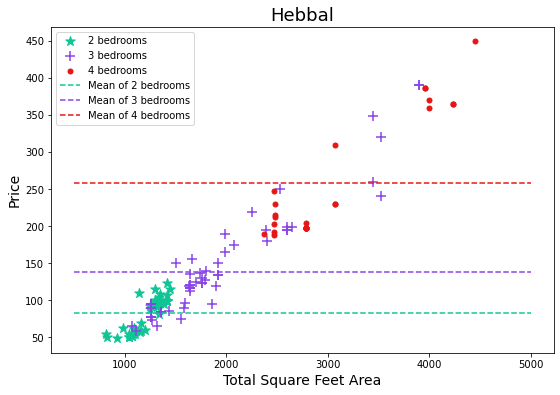

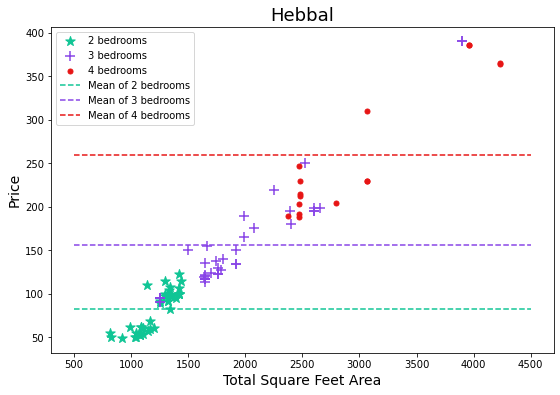

In [130]:
#Before outliers removal
print(df7.shape)
loc = 'Hebbal'
scatter_plot(df7,loc)

# After outliers removal
print(df9.shape)
scatter_plot(df9,loc)

<a class="anchor" id="3.2"></a>

### Bar Chart for the top 5 values of (location) feature

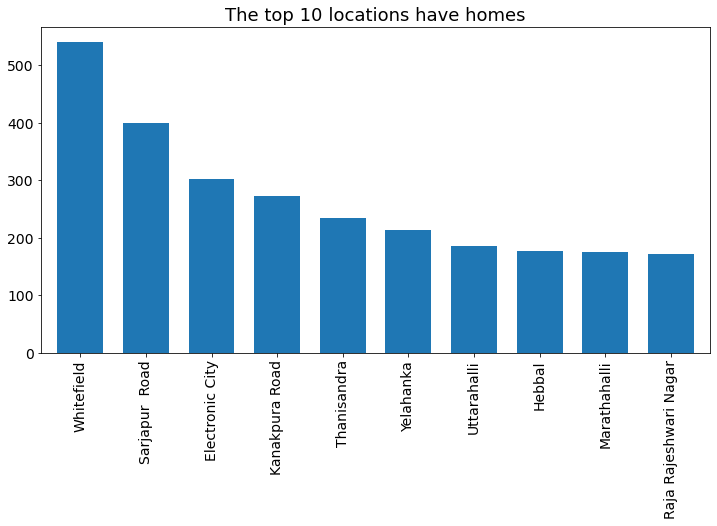

In [131]:
matplotlib.rcParams['figure.figsize'] = (12,6)

locs = df["location"].value_counts(ascending = False)[:10]
locs.plot.bar(fontsize = 14,width=0.7)
plt.title('The top 10 locations have homes',fontsize = 18)
plt.show()

<a class="anchor" id="3.3"></a>

### Histogram chart for Number of bathrooms vs Count


In [132]:
def plot_hist(data,title,xlabel,color = 'b',size = (9,6)):
    
    matplotlib.rcParams['figure.figsize'] = size

    plt.hist (data, color = color)
    plt.title(title,fontsize = 18)
    plt.xlabel(xlabel,fontsize = 14)
    plt.ylabel("Count",fontsize = 14)
    plt.show()

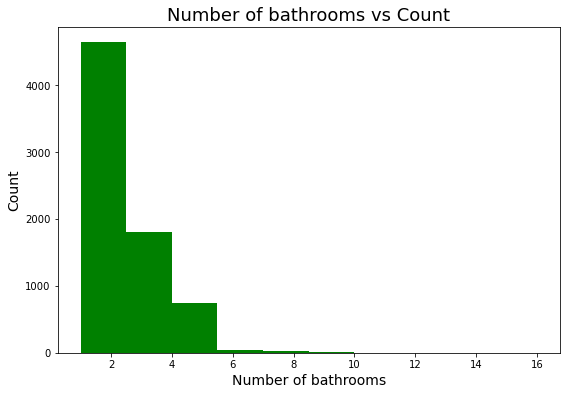

In [133]:
plot_hist(df9.bath,title = 'Number of bathrooms vs Count',xlabel = "Number of bathrooms",color = 'green')

<a class="anchor" id="3.4"></a>

### Histogram chart for Number of bedrooms vs Count

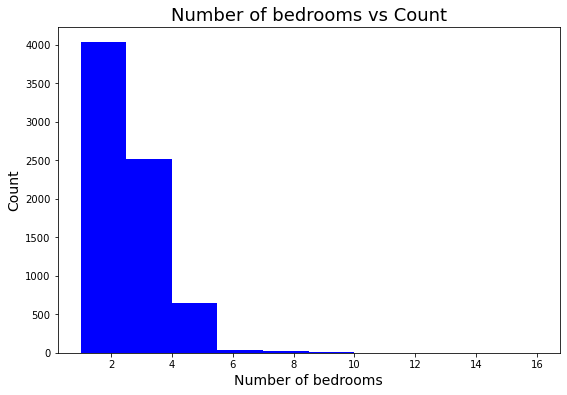

In [134]:
plot_hist(df9.bedroom,title = 'Number of bedrooms vs Count',xlabel = "Number of bedrooms",color = 'blue')

<a class="anchor" id="3.5"></a>

### Line chart for the relation between Total price vs Number of bedrooms and bathrooms

In [135]:
def line_plot(df,lines,y_axis,title, y_label,x_label,size =(9,6)):
    matplotlib.rcParams['figure.figsize'] = size 
    for i in range(len(lines)):
        data = df.groupby(lines[i]).agg('mean')[y_axis]
        data.plot.line(label = lines[i].capitalize())

    plt.title(title,fontsize= 16)
    plt.ylabel(y_label,fontsize= 14)
    plt.xlabel(x_label, fontsize = 14)
    plt.legend()

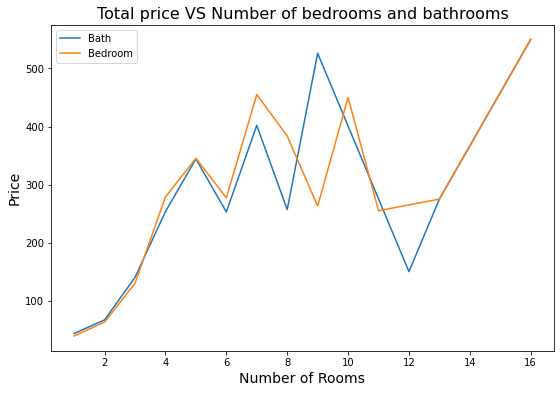

In [136]:
title = "Total price VS Number of bedrooms and bathrooms"
x_label='Number of Rooms'
y_label='Price'
line_plot(df9,lines = ['bath', 'bedroom'],y_axis='price',title = title,y_label = y_label,x_label= x_label)

<a class="anchor" id="3.6"></a>

### Trend chart for Total square feet vs Total price

In [137]:
def trend_plot(x,y,title,x_label, y_label):
    trend = np.polyfit(x,y,1)
    plt.plot(x,y,'.')
    trendpoly = np.poly1d(trend) 
    plt.plot(x,trendpoly(x))
    
    plt.title(title,fontsize = 16)
    plt.xlabel(x_label,fontsize = 14)
    plt.ylabel(y_label,fontsize = 14)


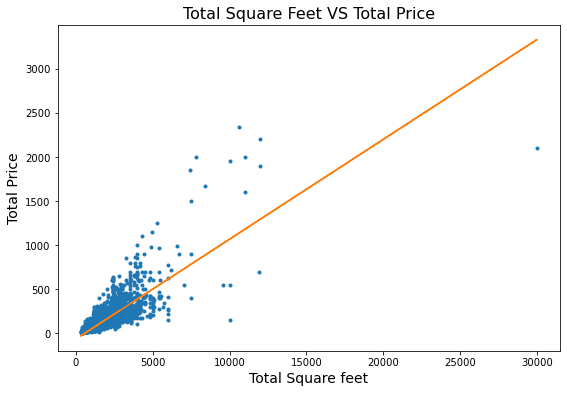

In [138]:
title = "Total Square Feet VS Total Price"
x_label='Total Square feet'
y_label='Total Price'

x = df9['total_sqft']
y = df9['price']

trend_plot(x, y,title, x_label, y_label)

<a class="anchor" id="4.0"></a>

## SAVE CLEANED DATASET

In [139]:
# drop unneccessery features
df9 = df9.drop(['size','price_per_sqft'],axis=1)

# rename bath col s bathroom
df9 = df9.rename(columns={'bath':'bathroom'})

# convert bathroom datatype from float to int32
df9.bathroom = df9.bathroom.astype(int)

# move price col to the las position
price = df9.pop('price')
df9.insert(df9.shape[1], 'price',price)

In [140]:
df9.head()

,location,total_sqft,bathroom,bedroom,price
0,1st Block Jayanagar,2850.0,4,4,428.0
1,1st Block Jayanagar,1630.0,3,3,194.0
2,1st Block Jayanagar,1875.0,2,3,235.0
3,1st Block Jayanagar,1200.0,2,3,130.0
4,1st Block Jayanagar,1235.0,2,2,148.0


<a class="anchor" id="4.1"></a>

### Use One Hot Encoding For (location) feature

In [141]:
len(df9.location.unique())

241

In [142]:
dummies = pd.get_dummies(df9.location)
dummies = dummies.drop('other', axis = 1)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
df9 = df9.drop('location',axis=1)

In [144]:
df10 = pd.concat([dummies, df9], axis = 1)
df10.sample(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,total_sqft,bathroom,bedroom,price
4756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1215.0,2,2,45.0
7032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1175.0,2,2,47.0
9180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1537.0,3,3,110.0


<a class="anchor" id="4.2"></a>

### Save dataset as csv file

In [145]:
df10.to_csv('HomePrices.csv', index = False)

<a class="anchor" id="5.0"></a>

## MODELS

In [146]:
# Splitting data independent variables (x) and dependent variable(y)
y = df10.price.to_numpy()
X = df10.drop(['price'], axis = 1).to_numpy()

<a class="anchor" id="5.1"></a>

## Multivariate LinearRegression model 
Multivariate linear regression is an approach for predicting a quantitative response using multiple feature (or "predictor" or "input variable")
It takes the following form:

$$ Y_i = \alpha + \beta_{1}x_{i}^{(1)} + \beta_{2}x_{i}^{(2)}+....+\beta_{n}x_{i}^{(n)}$$

Where:
- $Y_i$  is the response
- $x_i$  is the feature
- $\alpha$  is the intercept
- $\beta$  is the coefficient for $x$
- $n$ number of features


<a class="anchor" id="5.1.1"></a>

### Splitting data to training set ans testing set

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2021)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (5803, 243)
y_train shape:  (5803,)
X_test shape:  (1451, 243)
y_test shape:  (1451,)


<a class="anchor" id="5.1.2"></a>

### Build LinearRegression model 

In [148]:
# building the regression model
LR_model = LinearRegression()

<a class="anchor" id="5.1.3"></a>

### Train LinearRegression model 

In [149]:
LR_model.fit(X_train,y_train)

LinearRegression()

<a class="anchor" id="5.1.4"></a>

### Evaluate LinearRegression model 

In [150]:
# calculate testing accuacy
sc =LR_model.score(X_test,y_test)
print('The regression model has validation score = {:0.2f}%'.format(sc*100))

The regression model has validation score = 76.50%


,> The accuracy of the model is low a little bit

<a class="anchor" id="5.1.5"></a>

### Predict LinearRegression model 

In [151]:
y_pred = LR_model.predict(X_test)

In [152]:
print('Frist 5 prediction values is :\n{}'.format(y_pred[:5]))
print('\nFrist 5 actual values is :\n{}'.format(y_test[:5]))

Frist 5 prediction values is :
[ 48.81846618  39.66870638  59.84304253 120.18668544 155.74255746]

Frist 5 actual values is :
[ 53.35  49.    60.   105.   122.  ]


<a class="anchor" id="5.2"></a>

## Searching for best K-Fold cross validation parameters


In [153]:
folds = range(2,11)
test_sizes = [0.3,0.2,0.15]
acc_dict = dict()

for s in test_sizes:
    # record mean and min/max of each set of results
    means, mins, maxs = list(),list(),list()
    print('>Test size = %2d%%:\n'% (100*s))
    for k in folds:
        # define the test condition
        start_time = time.time()
        cv = ShuffleSplit(n_splits = k, test_size = s, random_state=2021)
        # evaluate k value
        scores = cross_val_score(LinearRegression(),X, y, cv = cv)
        k_mean, k_min, k_max = scores.mean(), scores.min(), scores.max()
        # report performance
        print('\t>folds=%2d -- average accuracy=%.3f (min=%.3f, max=%.3f) -- takes=%.3f sec' % (k, k_mean, k_min, k_max,time.time()-start_time))
        # store mean accuracy
        means.append(k_mean)
        # store min and max relative to the mean
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    acc_dict[str(s)] = {'folds':list(folds),
                        'means':means,
                        'mins':mins,
                        'maxs':maxs
                       }
    print()

>Test size = 30%:

	>folds= 2 -- average accuracy=0.759 (min=0.746, max=0.771) -- takes=16.904 sec
	>folds= 3 -- average accuracy=0.752 (min=0.738, max=0.771) -- takes=27.357 sec
	>folds= 4 -- average accuracy=0.750 (min=0.738, max=0.771) -- takes=41.780 sec
	>folds= 5 -- average accuracy=0.748 (min=0.738, max=0.771) -- takes=24.974 sec
	>folds= 6 -- average accuracy=0.751 (min=0.738, max=0.771) -- takes=7.019 sec
	>folds= 7 -- average accuracy=0.748 (min=0.727, max=0.771) -- takes=37.486 sec
	>folds= 8 -- average accuracy=0.748 (min=0.727, max=0.771) -- takes=16.457 sec
	>folds= 9 -- average accuracy=0.747 (min=0.727, max=0.771) -- takes=3.822 sec
	>folds=10 -- average accuracy=0.744 (min=0.722, max=0.771) -- takes=29.231 sec

>Test size = 20%:

	>folds= 2 -- average accuracy=0.779 (min=0.765, max=0.792) -- takes=0.899 sec
	>folds= 3 -- average accuracy=0.775 (min=0.765, max=0.792) -- takes=5.522 sec
	>folds= 4 -- average accuracy=0.766 (min=0.740, max=0.792) -- takes=1.524 sec
	>fold

<a class="anchor" id="5.2.1"></a>

### Plot the k-Fold models accuracy

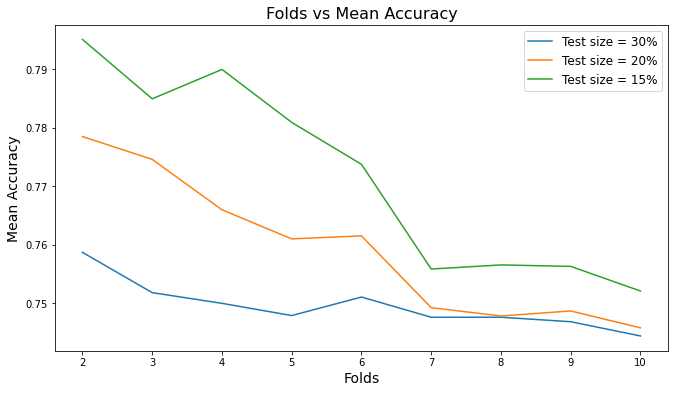

In [154]:
matplotlib.rcParams['figure.figsize'] = (11,6) 

for key, dict_ in acc_dict.items():
    test_size = int(100*float(key))
    plt.plot(dict_['folds'],dict_['means'], label='Test size = '+str(test_size)+'%')
    
plt.title("Folds vs Mean Accuracy",fontsize= 16)
plt.ylabel('Mean Accuracy',fontsize= 14)
plt.xlabel('Folds', fontsize = 14)
plt.legend(fontsize = 12)
plt.show()

<a class="anchor" id="5.2.2"></a>

### Best Model parameters

In [155]:
max_acc=0
for key, dict_ in acc_dict.items():
    if  max(dict_['means'])> max_acc:
        max_acc = max(dict_['means'])
        folds = dict_['means'].index(max_acc)
        test_size=float(key)

print('Best Accuracy = {}%\nTest size = {}%\nFolds = {}\n'.format(round(100*max_acc),100*test_size,folds))

Best Accuracy = 80%
Test size = 15.0%
Folds = 0



<a class="anchor" id="5.2.3"></a>

### Apply the best LinearRegression model

In [164]:
cv = ShuffleSplit(n_splits = folds, test_size = test_size, random_state=2021)
final_RL_model = LinearRegression()

<a class="anchor" id="5.2.4"></a>

### Testing the best LinearRegression mode

In [166]:
#y_pred = cross_val_predict(final_RL_model,X_test, y_test, cv=folds)

#print('Frist 5 prediction values is :\n{}'.format(y_pred[:5]))
#print('\nFrist 5 actual values is :\n{}'.format(y_test[:5]))
#print('\nFinal accuracy: ',round(100*max_acc))
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.67160287, 0.75206191, 0.76901146, 0.75943488, 0.78462727])

> The accuracy of the model is pretty good but we wanna to improve it

In [167]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.747348,{'normalize': True}
1,lasso,0.643449,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.505930,"{'criterion': 'friedman_mse', 'splitter': 'best'}"
